In [2]:
!pip install mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 7.4 MB/s eta 0:00:00


## Mistral Client Intialization

In [5]:
from mistralai import Mistral



import os


os.environ["MISTRAL_API_KEY"] = "your key here"

# Instantiate the MistralClient to create a client object
client = Mistral(os.environ["MISTRAL_API_KEY"])


# Use the client object to list all available models
models = client.models.list()

# Iterate over the list of models and print each one on a new line
for model in models.data:
    print(model.id)


ministral-3b-2410
ministral-3b-latest
ministral-8b-2410
ministral-8b-latest
open-mistral-7b
mistral-tiny
mistral-tiny-2312
open-mistral-nemo
open-mistral-nemo-2407
mistral-tiny-2407
mistral-tiny-latest
open-mixtral-8x7b
mistral-small
mistral-small-2312
open-mixtral-8x22b
open-mixtral-8x22b-2404
mistral-small-2402
mistral-small-2409
mistral-medium-2312
mistral-medium
mistral-medium-latest
mistral-large-2402
mistral-large-2407
mistral-large-2411
mistral-large-latest
pixtral-large-2411
pixtral-large-latest
mistral-large-pixtral-2411
codestral-2405
codestral-2501
codestral-latest
codestral-2412
codestral-2411-rc5
codestral-mamba-2407
open-codestral-mamba
codestral-mamba-latest
pixtral-12b-2409
pixtral-12b
pixtral-12b-latest
mistral-small-2501
mistral-small-2503
mistral-small-latest
mistral-saba-2502
mistral-saba-latest
mistral-embed
mistral-moderation-2411
mistral-moderation-latest
mistral-ocr-2503
mistral-ocr-latest


## Calculation of embedding

In [7]:
sample_sentence = "A young wizard fights evil."
sample_embed = client.embeddings.create(inputs=[sample_sentence])
clean_sample_embed =  sample_embed.data[0].embedding
print(len(clean_sample_embed))
print(clean_sample_embed[:10])

1024
[-0.032470703125, -0.002910614013671875, 0.06439208984375, 0.020599365234375, 0.00814056396484375, 0.021026611328125, 0.0465087890625, -0.003429412841796875, -0.022308349609375, -0.05792236328125]


## Semantic search with cosine similarity

In [8]:
dish_descriptions = [
    "Grilled steak with garlic butter",       # Meat
    "Seared salmon with lemon dill sauce",    # Fish
    "Roasted vegetable medley with herbs",    # Veggie
    "Spicy tofu stir-fry with vegetables",    # Asian
    "Tacos with spicy chicken and salsa",     # Mexican
    "Spicy chili con carne with beans",       # Spicy
    "Chocolate lava cake with vanilla ice cream",  # Sweet
    "Creamy tomato basil soup",               # Liquid
    "Cheeseburger with fries",                # Fast
    "Seared scallops with truffle oil",       # Fine
]

dish_embeds = client.embeddings.create(inputs=dish_descriptions)
dish_embeds_arr = []


for embed in dish_embeds.data:
  dish_embeds_arr.append(embed.embedding)

print(len(dish_embeds_arr))
print(len(dish_embeds_arr[0]))

10
1024


In [9]:
clean_embed = []

for embed in dish_embeds.data:
  clean_embed.append(embed.embedding)

print(clean_embed[2][:10])


[-0.0207977294921875, 0.01544189453125, 0.050323486328125, -0.0026397705078125, -0.00760650634765625, 0.00821685791015625, 0.0034198760986328125, -0.00811004638671875, -0.0272674560546875, -0.0474853515625]


In [10]:
user_input = input("What do you prefer for dinner? ")
user_embed = client.embeddings.create(inputs=[user_input]).data[0].embedding
user_embed[:10]

What do you prefer for dinner? hot dog


[-0.0123748779296875,
 -0.00995635986328125,
 0.0190277099609375,
 0.046356201171875,
 0.01195526123046875,
 0.0177154541015625,
 0.006557464599609375,
 -0.0210723876953125,
 -0.0021228790283203125,
 0.01029205322265625]

In [11]:
from scipy.spatial.distance import cosine

print (1 - cosine(user_embed, dish_embeds_arr[0]))
print (1 - cosine(user_embed, dish_embeds_arr[1]))
print (1 - cosine(user_embed, dish_embeds_arr[2]))

0.6602092428814766
0.63926523693931
0.6431461336176675


In [12]:
from scipy.spatial.distance import cosine, cdist
import numpy as np

distances = cdist(np.array(user_embed).reshape(1, -1), dish_embeds_arr, "cosine")

mostRelevant = np.argmin(distances) #index of the most relevant movie

print(f"most relevant index: {mostRelevant}")
print(f"Then you might find tasty: {dish_descriptions[mostRelevant]}")


most relevant index: 8
Then you might find tasty: Cheeseburger with fries


## Pinecone storage and semantic search

In [13]:
!pip install pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 4.1 MB/s eta 0:00:00


In [26]:
import pinecone

os.environ["PINECONE_API_KEY"] = "your key here"
from pinecone import Pinecone, ServerlessSpec

pcone = Pinecone()


In [40]:
existing_indexes = pcone.list_indexes()
existing_index_names = [index.name for index in existing_indexes]

# Check and delete sich index if it already exist
if 'dish-embeddings' in existing_index_names:
  pcone.delete_index('dish-embeddings')
# Create fresh index
pcone.create_index(
  name='dish-embeddings', dimension=1024, metric='cosine',
  spec=ServerlessSpec(cloud='aws', region='us-east-1')
)


{
    "name": "dish-embeddings",
    "metric": "cosine",
    "host": "dish-embeddings-6k0twet.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 1024,
    "deletion_protection": "disabled",
    "tags": null
}

In [41]:
index = pcone.Index('dish-embeddings')

In [42]:
for i, embed in enumerate(dish_embeds_arr):
    index.upsert([(f'dish_{i}', embed)])

In [45]:
result = index.query(vector=[user_embed], top_k=1)
closest_dish_id = result['matches'][0]['id']
print(closest_dish_id)
closest_dish_index = int(closest_dish_id.split('_')[1])
print(closest_dish_index)
print(dish_descriptions[closest_dish_index])

dish_8
8
Cheeseburger with fries


## Heat map Visualization

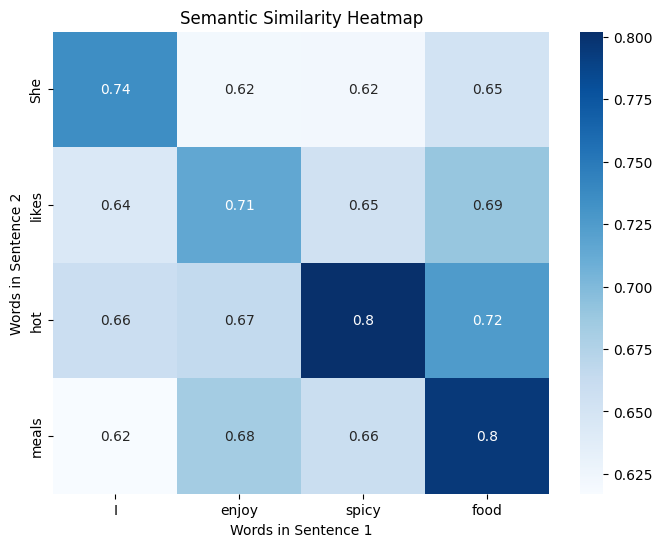

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Define the sentences and words
sentence1 = ["I", "enjoy", "spicy", "food"]
sentence2 = ["She", "likes", "hot", "meals"]

# Generate embeddings for each word
embeddings1 = client.embeddings.create(inputs=sentence1)
embeddings2 = client.embeddings.create(inputs=sentence2)

# Clean embed arrays
embeddings1_arr = []
embeddings2_arr = []

for embed in embeddings1.data:
  embeddings1_arr.append(embed.embedding)

for embed in embeddings2.data:
  embeddings2_arr.append(embed.embedding)


# Compute cosine similarity between each pair of words
similarity_scores = cosine_similarity(embeddings2_arr, embeddings1_arr)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_scores, annot=True, cmap='Blues', xticklabels=sentence1, yticklabels=sentence2)

# Set titles and labels
plt.title('Semantic Similarity Heatmap')
plt.xlabel('Words in Sentence 1')
plt.ylabel('Words in Sentence 2')

# Show the heatmap
plt.show()

## t-SNE Visualizations

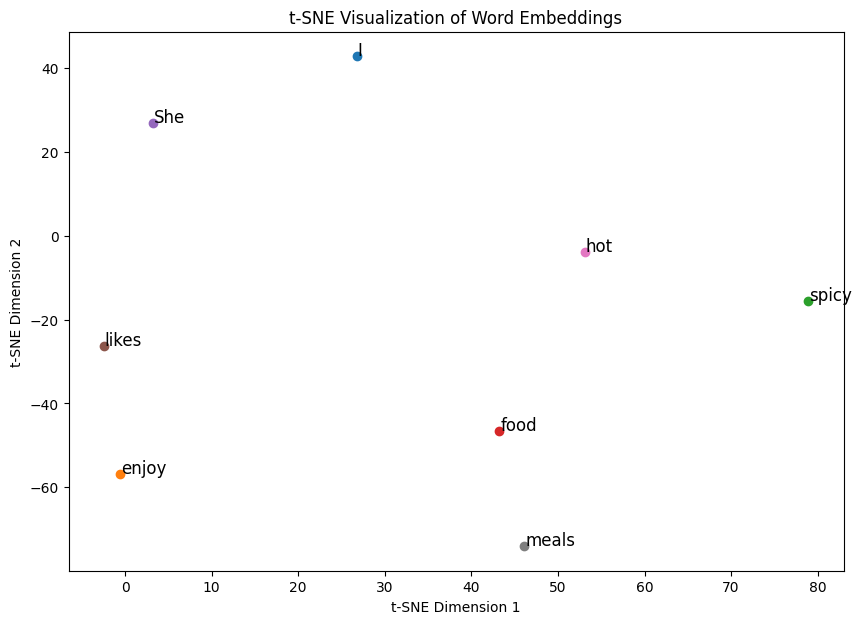

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

# Define the sentences and words
sentence1 = ["I", "enjoy", "spicy", "food"]
sentence2 = ["She", "likes", "hot", "meals"]

# Generate embeddings for each word
embeddings1 = client.embeddings.create(inputs=sentence1)
embeddings2 = client.embeddings.create(inputs=sentence2)

# Clean embed arrays
embeddings1_arr = []
embeddings2_arr = []

for embed in embeddings1.data:
    embeddings1_arr.append(embed.embedding)

for embed in embeddings2.data:
    embeddings2_arr.append(embed.embedding)

# Combine embeddings and create labels
combined_embeddings = np.array(embeddings1_arr + embeddings2_arr)
labels = sentence1 + sentence2

# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_results = tsne.fit_transform(combined_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(10, 7))
for i, label in enumerate(labels):
    x, y = tsne_results[i, :]
    plt.scatter(x, y)
    plt.text(x+0.1, y+0.1, label, fontsize=12)

plt.title('t-SNE Visualization of Word Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

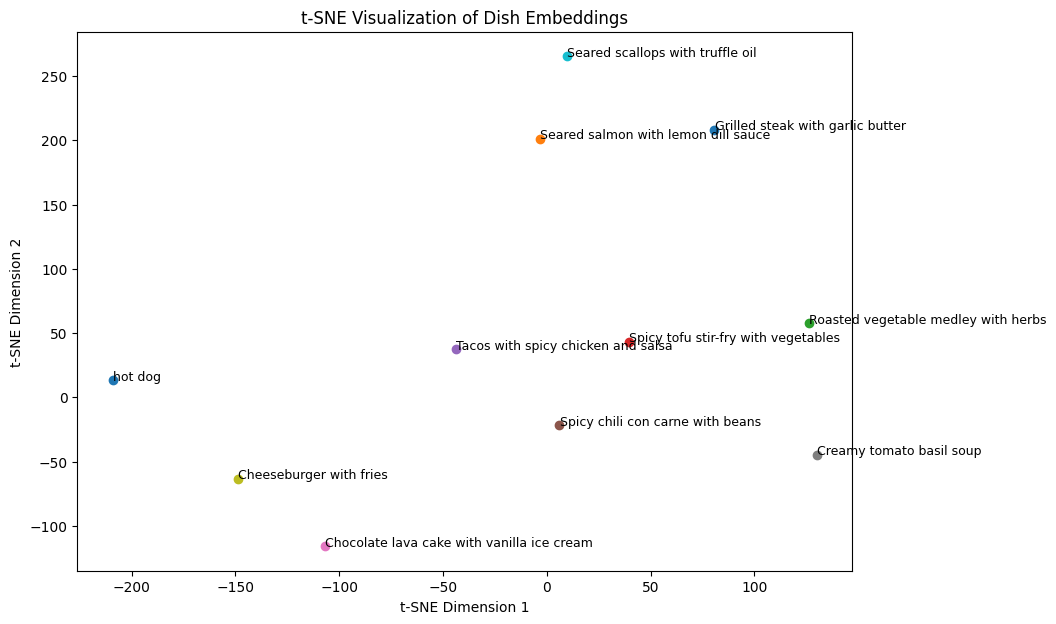

In [49]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


dish_embeds_arr.append(user_embed)
dish_descriptions.append(user_input)

dish_embeds_np_arr = np.array(dish_embeds_arr)
# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_results = tsne.fit_transform(dish_embeds_np_arr)

# Plot the t-SNE results
plt.figure(figsize=(10, 7))
for i, label in enumerate(dish_descriptions):
    x, y = tsne_results[i, :]
    plt.scatter(x, y)
    plt.text(x + 0.1, y + 0.1, label, fontsize=9)

plt.title('t-SNE Visualization of Dish Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()